In [3]:
import re
text = "Your journey starts with one step"
preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
preprocessed = [s.strip() for s in preprocessed if s and s.strip()]
print(preprocessed)

['Your', 'journey', 'starts', 'with', 'one', 'step']


In [4]:
import torch
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_tensor = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_tensor.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [5]:
# i) Intermediate step: compute attention scores ω between the query x(2) and all other input elements as a dot
#    product. 

In [6]:
inputs = embedding_tensor.weight.data
print(inputs.data)

tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]])


In [7]:
# dot product all x values with respect to x(2) to get ,a, attention weights
query = inputs[1]
print("%s\n"%query)
attn_scores_2 = torch.empty(inputs.shape[0])
for i , x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
print(attn_scores_2)

tensor([0.9178, 1.5810, 1.3010])

tensor([-0.1913,  5.0345,  0.6438, -0.3341, -1.3706, -5.6812])


In [8]:
# ii) noramlise with standard softmax
torch.set_printoptions(sci_mode=False, precision=3)
import torch.nn.functional as F

attn_weights_2_tmp = F.softmax(attn_scores_2, dim=0)
print("Attention weights:", [f"{weight:.4f}" for weight in attn_weights_2_tmp])
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: ['0.0052', '0.9765', '0.0121', '0.0046', '0.0016', '0.0000']
Sum: tensor(1.000)


In [9]:
# iii) attention weights found and normalised, now compute context vector z, with respect to x(2), z(2). This 
#      context vector is a combination of all input vectors x(1) - x(t) weighed by attention weights
#      z(2) = ∑ 𝑥 ⋅ α ; z(2) as attention weights, α, are computed with respect to x(2)

In [10]:
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2_tmp[i] * x_i
print(context_vec_2)

tensor([0.910, 1.545, 1.261])


In [43]:
#see more below

In [16]:
# dot product for all pair x_i, x_j
attn_scores = torch.empty(6,6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(attn_scores)

tensor([[ 0.174, -0.191,  0.493, -0.113, -0.342, -0.580],
        [-0.191,  5.034,  0.644, -0.334, -1.371, -5.681],
        [ 0.493,  0.644,  1.693, -0.522, -1.442, -3.238],
        [-0.113, -0.334, -0.522,  2.414,  1.505,  2.000],
        [-0.342, -1.371, -1.442,  1.505,  1.848,  3.926],
        [-0.580, -5.681, -3.238,  2.000,  3.926, 10.668]])


In [19]:
# use matrix multiplication with transpose of vector inputs
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[ 0.174, -0.191,  0.493, -0.113, -0.342, -0.580],
        [-0.191,  5.034,  0.644, -0.334, -1.371, -5.681],
        [ 0.493,  0.644,  1.693, -0.522, -1.442, -3.238],
        [-0.113, -0.334, -0.522,  2.414,  1.505,  2.000],
        [-0.342, -1.371, -1.442,  1.505,  1.848,  3.926],
        [-0.580, -5.681, -3.238,  2.000,  3.926, 10.668]])


In [20]:
attn_weights = torch.softmax(attn_scores, dim=1)
print(attn_weights)

tensor([[    0.205,     0.142,     0.282,     0.154,     0.122,     0.096],
        [    0.005,     0.976,     0.012,     0.005,     0.002,     0.000],
        [    0.166,     0.193,     0.552,     0.060,     0.024,     0.004],
        [    0.035,     0.028,     0.023,     0.442,     0.178,     0.292],
        [    0.011,     0.004,     0.004,     0.072,     0.101,     0.808],
        [    0.000,     0.000,     0.000,     0.000,     0.001,     0.999]])


In [31]:
for i in range(attn_weights.shape[1]):
    print("Sum for row %d: %s"% (i+1,sum(attn_weights[i])))

# sum(attn_weights[1])

Sum for row 1: tensor(1.)
Sum for row 2: tensor(1.000)
Sum for row 3: tensor(1.)
Sum for row 4: tensor(1.)
Sum for row 5: tensor(1.)
Sum for row 6: tensor(1.)


In [33]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[ 0.082,  0.244, -0.284],
        [ 0.910,  1.545,  1.261],
        [ 0.874,  0.228,  0.045],
        [-1.147,  0.290, -1.005],
        [-2.428, -0.528, -1.282],
        [-2.838, -0.783, -1.409]])


In [ ]:
#now changing ,a , such that it is trainable rather than being a direct output from the cross dot product with respect to a 
# x(_) value
# using scaled dot-product attention

In [45]:
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2
print(x_2)

tensor([0.918, 1.581, 1.301])


In [57]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=True)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=True)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=True)
print(W_query, W_key, W_value)

Parameter containing:
tensor([[0.296, 0.517],
        [0.252, 0.689],
        [0.074, 0.867]], requires_grad=True) Parameter containing:
tensor([[0.137, 0.102],
        [0.184, 0.726],
        [0.315, 0.687]], requires_grad=True) Parameter containing:
tensor([[0.076, 0.197],
        [0.316, 0.402],
        [0.119, 0.827]], requires_grad=True)


In [59]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)
print(key_2)

tensor([0.766, 2.690], grad_fn=<SqueezeBackward4>)
tensor([0.826, 2.136], grad_fn=<SqueezeBackward4>)


In [64]:
keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)
print(f"\nKeys: {keys}\n\nValues: {values}")

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])

Keys: tensor([[-0.040, -0.211],
        [ 0.826,  2.136],
        [ 0.087, -0.126],
        [-0.239, -0.128],
        [-0.297, -0.316],
        [-0.977, -1.830]], grad_fn=<MmBackward0>)

Values: tensor([[-0.051, -0.145],
        [ 0.724,  1.892],
        [ 0.014,  0.037],
        [ 0.139, -0.641],
        [-0.060, -0.620],
        [-0.630, -2.040]], grad_fn=<MmBackward0>)


In [54]:
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(6.380, grad_fn=<DotBackward0>)


In [56]:
attn_scores_2 = query_2 @ keys.T
print(attn_scores_2)

tensor([-0.597,  6.380, -0.272, -0.527, -1.079, -5.670],
       grad_fn=<SqueezeBackward4>)


In [76]:
#All you need is attention:
# A(Q,K,V) = softmax( QK^T / SQRT(dk)) x V
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)


tensor([    0.007,     0.972,     0.009,     0.007,     0.005,     0.000],
       grad_fn=<SoftmaxBackward0>)


In [78]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.704, 1.830], grad_fn=<SqueezeBackward4>)


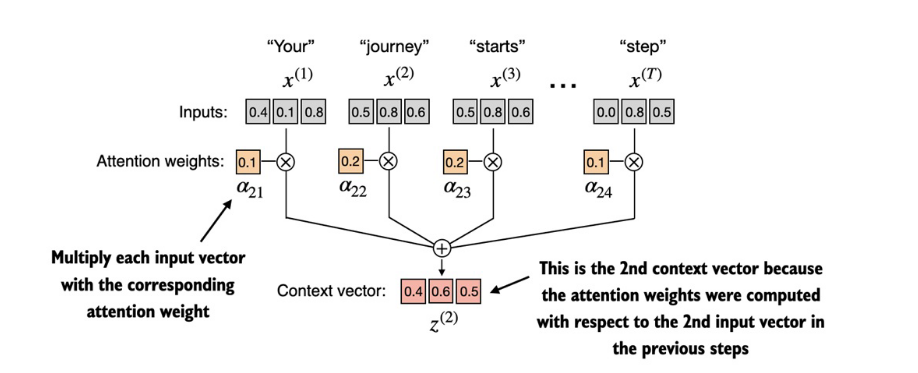

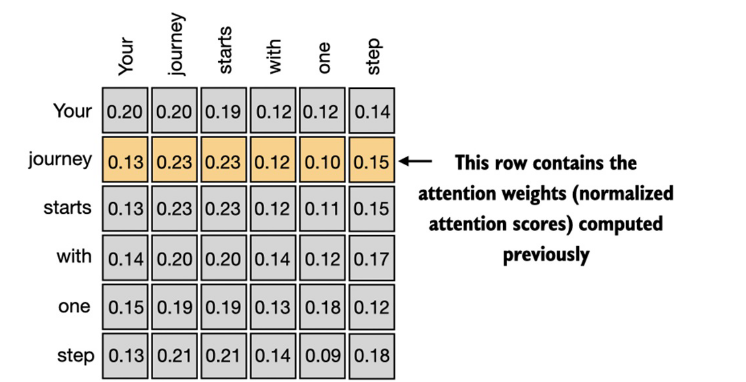

In [36]:
from IPython.display import Image, display
display(Image(filename='SIMPLEMASKS!!.PNG'))
display(Image(filename='attnetion.PNG'))
